In [41]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import shap
import os

In [43]:
season_mapping = {
    1: 'Winter', 2: 'Winter', 12: 'Winter', 
    3: 'Spring', 4: 'Spring', 5: 'Spring', 
    6: 'Summer', 7: 'Summer', 8: 'Summer', 
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}

month_mapping = {
    1: 'January', 2: 'February', 3: 'March',
    4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September',
    10: 'October', 11: 'November', 12: 'December'
}

In [47]:
# state = 'Michigan'

def create_frame(state, month_season, stat, target_column, model_sel):
    weather = pd.read_csv(f'collated_data/{state}.csv')[['Date','cdd','hdd','tavg']]
    weather['Date'] = pd.to_datetime(weather['Date'].astype(str), format='%Y%m')
    weather['Year'] = weather['Date'].dt.year
    if month_season == 'Month':
        mapping = month_mapping
    else:
        mapping = season_mapping
    
    weather[month_season] = weather['Date'].dt.month.map(mapping)
    weather_agg = weather.groupby(['Year',month_season])[stat].mean().reset_index()
    weather_agg = weather.groupby(['Year',month_season])[stat].mean().reset_index()
    weather_pivot = weather_agg.pivot(index='Year', columns=month_season, values=stat)
    weather_pivot.columns = ['_'.join(col).strip() for col in weather_pivot.columns.values]
    energy = pd.read_csv(f'power_consumption/{state}.csv')
    energy.set_index('Year', inplace=True)
    weathergy = pd.concat([weather_pivot, energy[['Residential sector', 'Commercial sector', 
                                                  'Industrial sector', 'Transportation sector', 'Total consumption']]], axis=1)
    
    X = weathergy.drop(columns=['Residential sector', 'Commercial sector', 'Industrial sector', 'Transportation sector', 'Total consumption'])
    y = weathergy[['Residential sector', 'Commercial sector', 'Industrial sector', 'Transportation sector', 'Total consumption']]
    if (model_sel == 'XGB'):
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
        model = XGBRegressor()
    if (model_sel == 'DecisionTree'):
        param_grid = {
            'max_depth': [3, 5, 7, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['squared_error', 'friedman_mse']
        }
        model = DecisionTreeRegressor()
    if (model_sel == 'RFR'):
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
        
        model = RandomForestRegressor()
    

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=3,
        n_jobs=-1
    )
    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    feature_importances = best_model.feature_importances_
    
    model.fit(X, y[target_column])
    feature_importances = model.feature_importances_

    importance_df = pd.DataFrame({
        "Feature": X.columns,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=True)

    return importance_df, state, target_column, grid_search.best_params_
        # features = X.columns
        # plt.figure(figsize=(12,6))
        # # plt.barh(features, rf_feature_importances)
        # plt.barh(importance_df['Feature'], importance_df['Importance'])
        # plt.title(f"Feature Importance for {target_column}")
        # plt.xlabel("Importance")
        # plt.ylabel("Features")
        # plt.show()
def output_results(model_sel, month_season):
    results = []
    for target_column in ['Residential sector', 'Commercial sector', 'Industrial sector', 'Transportation sector', 'Total consumption']:
        for state in os.listdir('collated_data'):
            state = state.replace('.csv', '')
            importance_df, state, target_column, best_params = create_frame(state, month_season, ['cdd', 'hdd'], target_column, model_sel)
            for index, row in importance_df.iterrows():
                results.append({
                    "State": state,
                    "Target Column": target_column,
                    "Feature": row['Feature'],
                    "Importance": row['Importance'],
                    "Best Params": best_params
                })
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'feature_importances/feature_importance_results_{model_sel}.csv', index=False)

models = ['RFR']
for model_sel in models:
    output_results(model_sel, 'Month')

C:\Users\vaibh\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\vaibh\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\vaibh\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


For Michigan, Spring contributes the most to the total consumption.


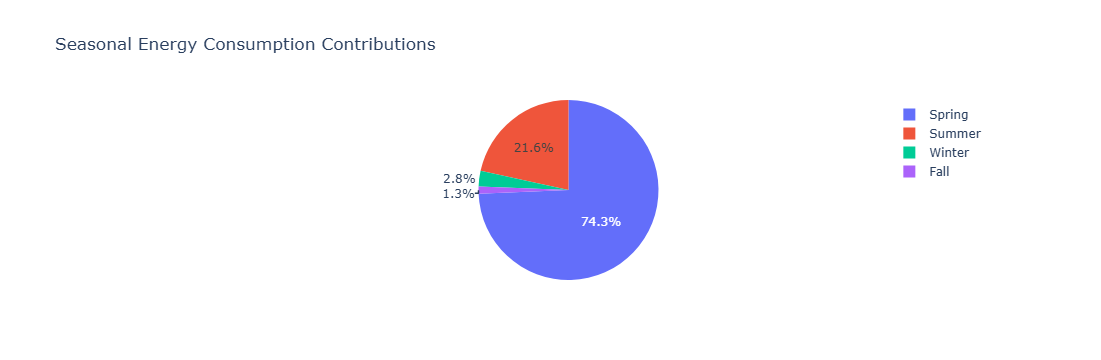

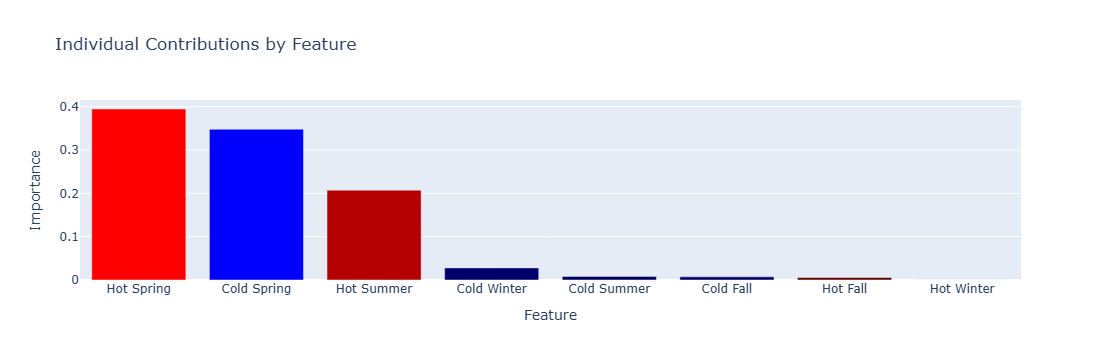

In [365]:
def aggregate_and_rank(df, df_m state, target_column):
    season_map = {
        "Winter": ["cdd_Winter", "hdd_Winter"],
        "Spring": ["cdd_Spring", "hdd_Spring"],
        "Summer": ["cdd_Summer", "hdd_Summer"],
        "Fall": ["cdd_Fall", "hdd_Fall"]
    }
    season_totals = {season: df[df["Feature"].isin(features)]["Importance"].sum() for season, features in season_map.items()}
    season_df = pd.DataFrame(list(season_totals.items()), columns=["Season", "Contribution"]).sort_values(by="Contribution", ascending=False)

    month_totals = {month: df_m[df_m["Feature"].str.contains(f"_{month}")]["Importance"].sum() for month in df_m["Feature"].str.split("_").str[1].unique()}
    month_df = pd.DataFrame(list(month_totals.items()), columns=["Month", "Contribution"]).sort_values(by="Contribution", ascending=False)

    top_contributor = season_df.iloc[0]
    second_contributor = season_df.iloc[1] if len(season_df) > 1 else None

    co_dominance_threshold = 0.05 

    if second_contributor is not None:
        diff = top_contributor["Contribution"] - second_contributor["Contribution"]

        if diff <= co_dominance_threshold:
            print(f"For {state}, {top_contributor['Season']} and {second_contributor['Season']} contribute the most")
        else:
            print(f"For {state}, {top_contributor['Season']} contributes the most to the {target_column.lower()}.")

    else:
        print(f"For {state}, {top_contributor['Season']} is the only major contributor to the {target_column.lower()}.")

    fig1 = px.pie(season_df, names='Season', values='Contribution', title="Seasonal Energy Consumption Contributions")

    df["Category"] = df["Feature"].apply(lambda x: "Hot " + x.split("_")[1] if "cdd" in x else "Cold " + x.split("_")[1])

    min_importance_blue = df[df['Category'].str.startswith('Cold')]['Importance'].min()
    max_importance_blue = df[df['Category'].str.startswith('Cold')]['Importance'].max()
    min_importance_red = df[df['Category'].str.startswith('Hot')]['Importance'].min()
    max_importance_red = df[df['Category'].str.startswith('Hot')]['Importance'].max()
    min_color_value = 100
    
    df["Color"] = df.apply(
        lambda row: f"rgb({min(255,int((row['Importance'] - min_importance_red) / (max_importance_red - min_importance_red) * (255 - min_color_value)
                               + min_color_value))}, 0, 0)" if "Hot" in row["Category"] 
        else f"rgb(0, 0, {min(255,int((row['Importance'] - min_importance_blue) / (max_importance_blue - min_importance_blue) * (255 - min_color_value)
                              + min_color_value))})", axis=1
    )
    
    df_sorted = df.sort_values(by="Importance", ascending=False)

    
    fig2 = go.Figure()

    
    fig2.add_trace(go.Bar(
        x=df_sorted["Category"], 
        y=df_sorted["Importance"],
        hoverinfo="text", 
        marker=dict(
            color=df_sorted["Color"],  
        )
    ))

    fig2.update_layout(
        title="Individual Contributions by Feature",
        xaxis_title="Feature",
        yaxis_title="Importance",
        showlegend=False
    )

    fig1.show()
    fig2.show()

aggregate_and_rank(importance_df, state, target_column)